# Sampling the posterior probability distribution of the AGN fraction (theta), by means of different Bayesian Computation techniques

In [49]:
install.packages("coda", '/Users/meme/anaconda3/lib/R/library')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [38]:
# Required packages
library(ggplot2)
library(gridExtra)

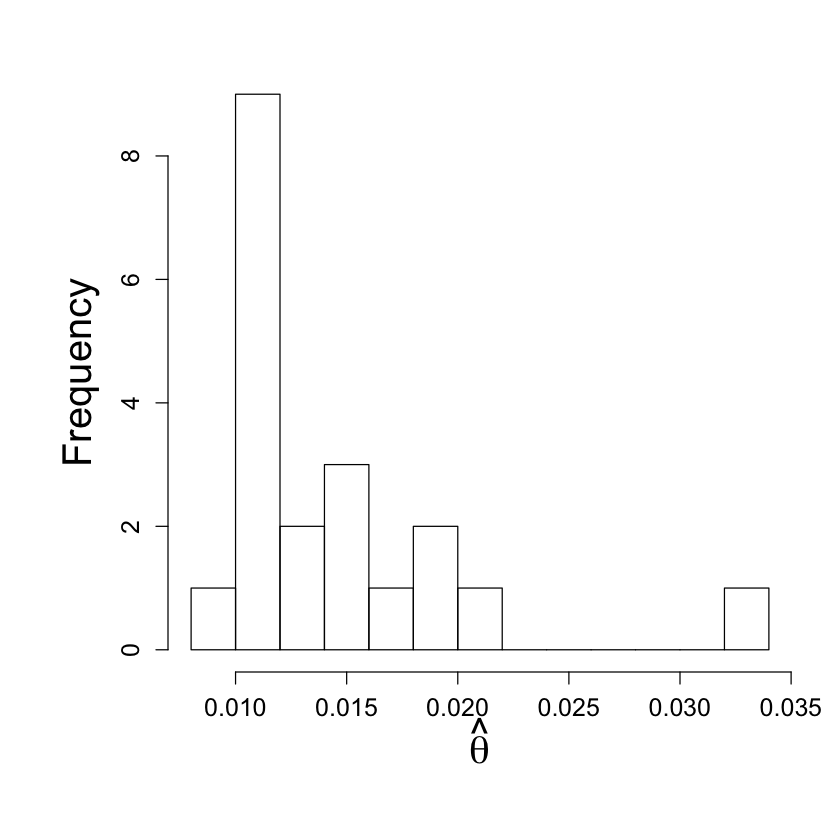

In [6]:
# DATA: 
data = data.frame(x = c(10,10,36,10,15,12,10,18,9,19,11,10,9,10,590,9,8,10,9,7), 
                  n=c(1083,855,3461,657,1208,1025,527,1668,583,582,917,857,680,917,53637,874,395,581,588,383)) 


#pdf("BetaBinom.pdf",8,6)
par(mfrow=c(1,1),mar=c(7,7,3,2))
hist(data$x/data$n,breaks=10,
     cex.axis=1.25,cex.lab=2,xlab=expression(hat(theta)),main="")
#dev.off()

# A Beta-Binomial Model for Overdispersion

Data: $x  = \{ (x_i,n_i)\}_{i=1,\ldots,20}$

$\left.
            \begin{array}{l}
             \bullet\ \ x_i \sim B(n_i,\theta),\\ 
              \quad p(x|\theta) = \prod_{i=1}^m\binom{n}{x}\theta^{x_i} (1-\theta)^{n_i-x_i}     \\[1ex]
              \bullet\ \ \theta \sim Beta(\alpha,\beta),\\
              \quad p(\theta|\alpha,\beta) = \underbrace{\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}}_{B(\alpha,\beta)^{-1}}
              \theta^{\alpha-1} (1-\theta)^{\beta-1}  
            \end{array}
            \right\} 
            \qquad \Rightarrow \qquad
            \begin{array}{l}
             \bullet\ \ \theta | x \sim Beta\left(\alpha+\sum x_i,\beta + \sum (n_i-x_i)\right) \\[1ex]
              \bullet\ \ x_i \sim Beta-bin(n,\alpha,\beta),
              \quad p(x_i|\alpha,\beta) = \binom{n_i}{x_i}\frac{B(x_i+\alpha,n_i-x_i+\beta)}{B(\alpha,\beta)} \\
              \quad \text{or more commonly, } 
              p(x_i|\eta,\kappa) = \binom{n_i}{x_i}\frac{B(x_i+\eta\kappa,n_i-x_i+(1-\eta)\kappa)}
              {B(\eta\kappa,(1-\eta)\kappa)} \\
              \quad \text{where, } \eta = \frac{\alpha}{\alpha + \beta} = E(\theta) \in (0,1), 
              \kappa = \alpha + \beta > 0
            \end{array}
$



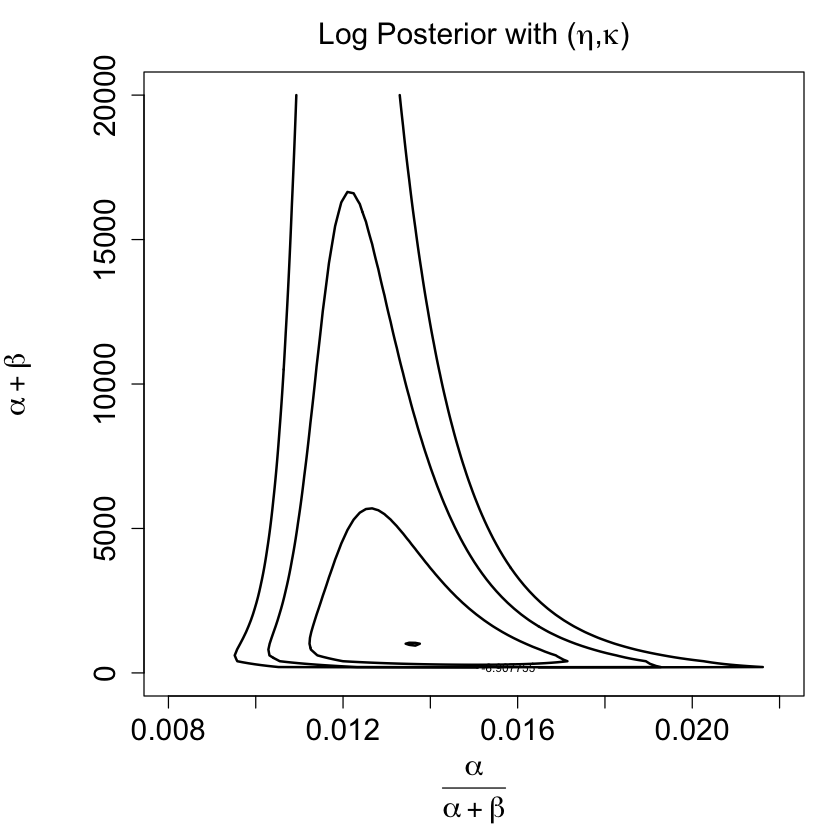

In [7]:
# Function to compute the log of the posterior for (eta,kappa) parameterization
# Use log for numerical accuracy
logpost = function (theta, data) 
{
  x = data[, 1]
  n = data[, 2]
  N = length(x)
  
  loglike=function(x,n,K,eta){
    lbeta(K * eta + x, K * (1 - eta) + n - x)-lbeta(K * eta, K * (1 - eta))
  }
  # if theta is not a matrix: 
  if(is.list(theta)) theta = data.matrix(theta)
  if(is.vector(theta)) theta = t(matrix(theta))
  
  logpost = matrix(0,nrow = dim(theta)[1])
  
  for(i in 1:dim(theta)[1]){
    eta = theta[i,1]
    K = theta[i,2]
    logpost[i] = sum(loglike(x,n,K,eta)) - 2 * log(1 + K) - log(eta) - log(1 - eta)
  }
  
  return(logpost)
}


# Compute the posterior d. on a grid
n.grid = 100
limits = c(.008,.022,1,20000) 
a.grid <- seq(limits[1], limits[2],length.out = n.grid)
b.grid <- seq(limits[3], limits[4], length.out = n.grid)

grid <- expand.grid(a.grid,b.grid)
#plot(grid$Var1, grid$Var2,type = "p",pch=16)

df <- data.frame(eta = grid$Var1, kappa = grid$Var2)
# (unnormalized) post.
df$post <- logpost(df[,1:2],data)
#df$post <- apply(df,1, function(params) logpost(params,data))
df$post <- df$post - max(df$post )

## Plot the posterior 
par(mfrow=c(1,1),mar=c(6,6,3,1.5), mgp=c(4.5, 1, 0)) #
contour(a.grid, b.grid, matrix(df$post, n.grid, n.grid), #6,
        levels = log(c(0.001,0.01,0.1,0.99)), #quantile(df$post,c(0.75,0.8,0.9,0.95,0.99)),
        lwd = 2, #drawlabels= FALSE,
        cex.axis=1.5,cex.lab=1.5,cex.main=1.5,
        xlab=expression(frac(alpha,alpha+beta)),ylab=expression(alpha+beta),
        main=expression(paste("Log Posterior with (",eta,",",kappa,")"))
        )

### Reparameterization:


$$(\phi_1,\phi_2) = \left(logit(\eta),log(\kappa)\right): \qquad
	p(\phi_1,\phi_2 | x) \propto
	p_{\eta,\kappa}\left(\frac{e^{\phi_1}}{1+e^{\phi_1}},e^{\phi_2} \middle| x \right) 
	 \frac{e^{\phi_1+\phi_2}}{(1+e^{\phi_1})^2}
$$

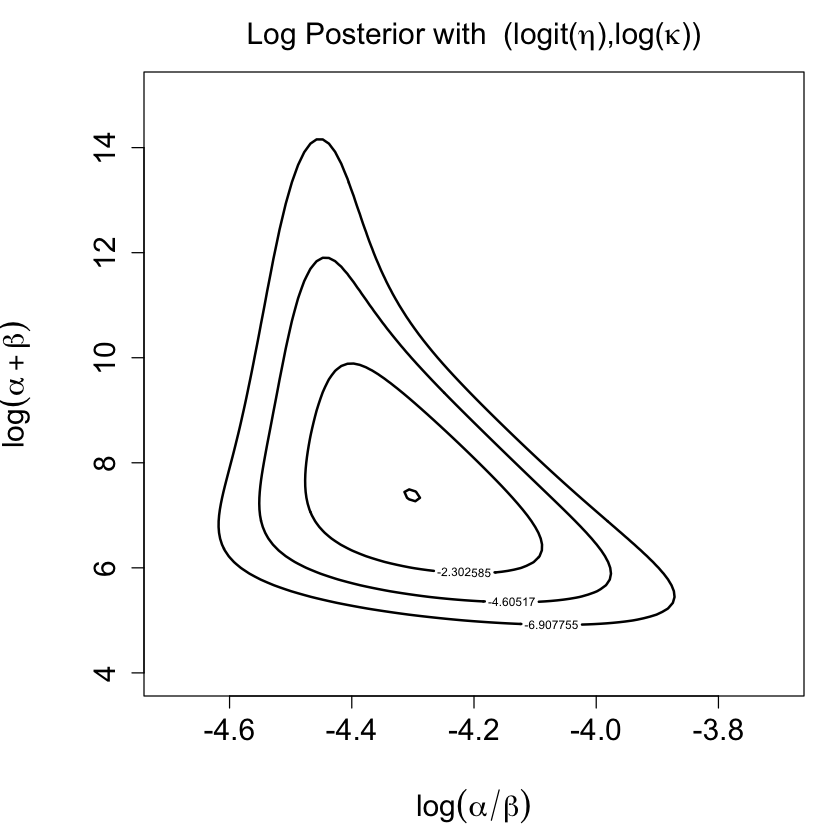

In [8]:
# Function to compute the log of the posterior, 
# for (logit(eta),log(kappa)) parameterization
logpost.R = function (theta, data) 
{
  x = data[, 1]
  n = data[, 2]
  N = length(x)
  
  loglike=function(x,n,K,eta){
    lbeta(K * eta + x, K * (1 - eta) + n - x)-lbeta(K * eta, K * (1 - eta))
  }
  # if theta is not a matrix: 
  if(is.list(theta)) theta = data.matrix(theta)
  if(is.vector(theta)) theta = t(matrix(theta))
  
  logpost = matrix(0,nrow = dim(theta)[1])
  
  for(i in 1:dim(theta)[1]){
    eta = exp(theta[i,1])/(1 + exp(theta[i,1]))
    K = exp(theta[i,2])
    logpost[i] = sum(loglike(x,n,K,eta)) + theta[i,2] - 2 * log(1 + exp(theta[i,2]))
  }
  
  return(logpost)
}

# Compute the posterior d. on a grid
limits2 = c(-4.7,-3.7,4,15) #c(-8,-4.5,3,16.5)
p1.grid <- seq(limits2[1], limits2[2],length.out = n.grid)
p2.grid <- seq(limits2[3], limits2[4], length.out = n.grid)
grid2 <- expand.grid(p1.grid,p2.grid)
#plot(grid2$Var1, grid2$Var2,type = "p",pch=16)

df2 <- data.frame(ph1 = grid2$Var1, ph2 = grid2$Var2)
df2$post <- logpost.R(df2[,1:2],data)
#df2$post <- apply(df2,1, function(params) logpost.R(params,data))
df2$post <- df2$post - max(df2$post)


# Plotting the posterior 
par(mfrow=c(1,1),mar=c(6,6,3,1.5), mgp=c(4.5, 1, 0)) #
contour(p1.grid, p2.grid, matrix(df2$post, n.grid, n.grid), #6,
        levels = log(c(0.001,0.01,0.1,0.99)), #quantile(df2$post,c(0.75,0.8,0.9,0.95,0.99)),
        lwd = 2, #drawlabels= FALSE,
        cex.axis=1.5,cex.lab=1.5,cex.main=1.5,
        xlab=expression(log(alpha / beta)),ylab=expression(log(alpha+beta)),
        main=expression(paste("Log Posterior with  (logit(",eta,"),log(",kappa,"))"))
        )



# Approximations Based on Posterior Modes


In [12]:
library(LearnBayes)

# Posterior mode approx.

print("Initial approximation")
theta0 = df2[which.max(df2$post),1:2]
theta0

print("Posterior Mode approximation by Nelder-Mead's Algorithm ")
fit=laplace(logpost.R,theta0,data)
fit

[1] "Initial approximation"


,ph1,ph2
3041,-4.29596,7.333333


[1] "Posterior Mode approximation by Nelder-Mead's Algorithm "


$mode
      ph1       ph2 
-4.301859  7.381423 

$var
             ph1         ph2
ph1  0.007578716 -0.03213102
ph2 -0.032131018  0.67065011

$int
          [,1]
[1,] -4495.986

$converge
[1] TRUE

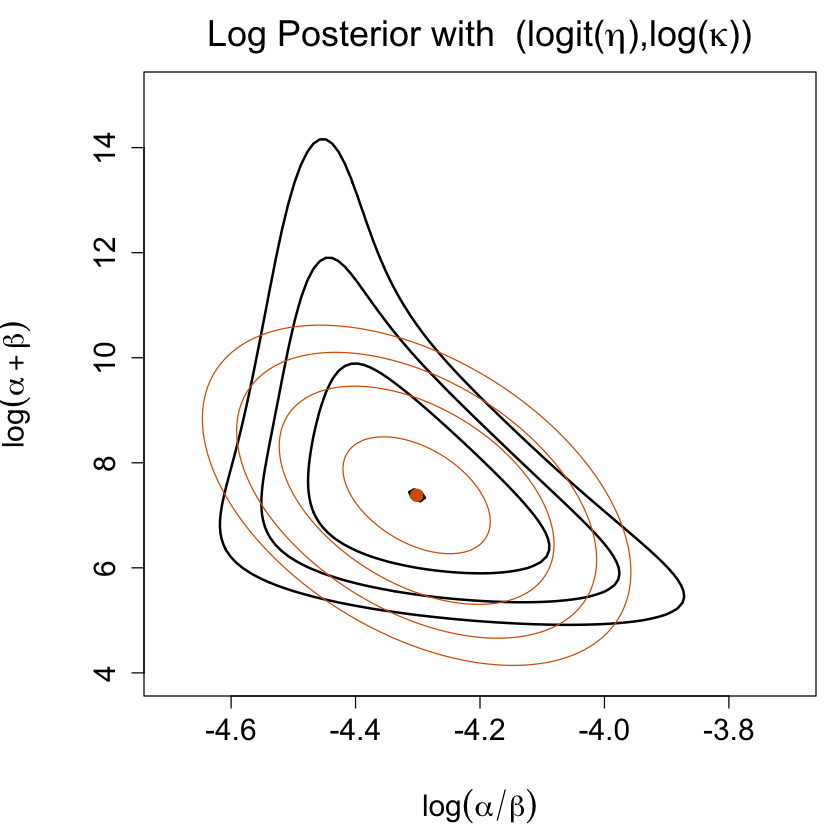

In [14]:
library(mvtnorm)

# Computes the logarithm of a bivariate normal density approximation 
npar=list(m=fit$mode,var=fit$var)
df2$norm.appr <- dmvnorm(df2[,1:2], mean = fit$mode, sigma = fit$var, log = TRUE)

# Define our own colours
col = c("#1B9E77","#7570B3","#D95F02")

# Plot
par(mfrow=c(1,1),mar=c(6,6,3,1), mgp=c(4.5, 1, 0)) #
contour(p1.grid, p2.grid, matrix(df2$post, n.grid, n.grid), #6,
        levels = log(c(0.001,0.01,0.1,0.99)), #quantile(df2$post,c(0.75,0.8,0.9,0.95,0.99)),
        lwd = 2, drawlabels= FALSE,
        cex.axis=1.5,cex.lab=1.5,cex.main=1.8,
        xlab=expression(log(alpha / beta)),ylab=expression(log(alpha+beta)),
        main=expression(paste("Log Posterior with  (logit(",eta,"),log(",kappa,"))")))
points(fit$mode[1],fit$mode[2],pch=20, col=col[3],cex=2)
contour(p1.grid, p2.grid, matrix(df2$norm.appr, n.grid, n.grid), #6,
        levels = log(c(0.001,0.01,0.1,0.99)), #quantile(df2$post,c(0.75,0.8,0.9,0.95,0.99)),
        col=col[3], drawlabels= FALSE,
        add=TRUE)


In [32]:
# 90% probability intervals for the parameters:
se=sqrt(diag(fit$var))
t(rbind(fit$mode-1.645*se,fit$mode+1.645*se))

# E(theta)=eta
eta = exp(fit$mode[1])/(1+exp(fit$mode[1]))
K = exp(fit$mode[2])
print(paste("eta=",round(eta,4),"kappa=",round(K,4)))

alfa = eta*K
beta = (1-eta)*K
print(paste("alfa=",round(alfa,4),"beta=",round(beta,4)))


ph1,-4.445066,-4.158653
ph2,6.034279,8.728566


[1] "eta= 0.0134 kappa= 1605.873"
[1] "alfa= 21.4583 beta= 1584.4147"



# Rejection Sampling (RS)


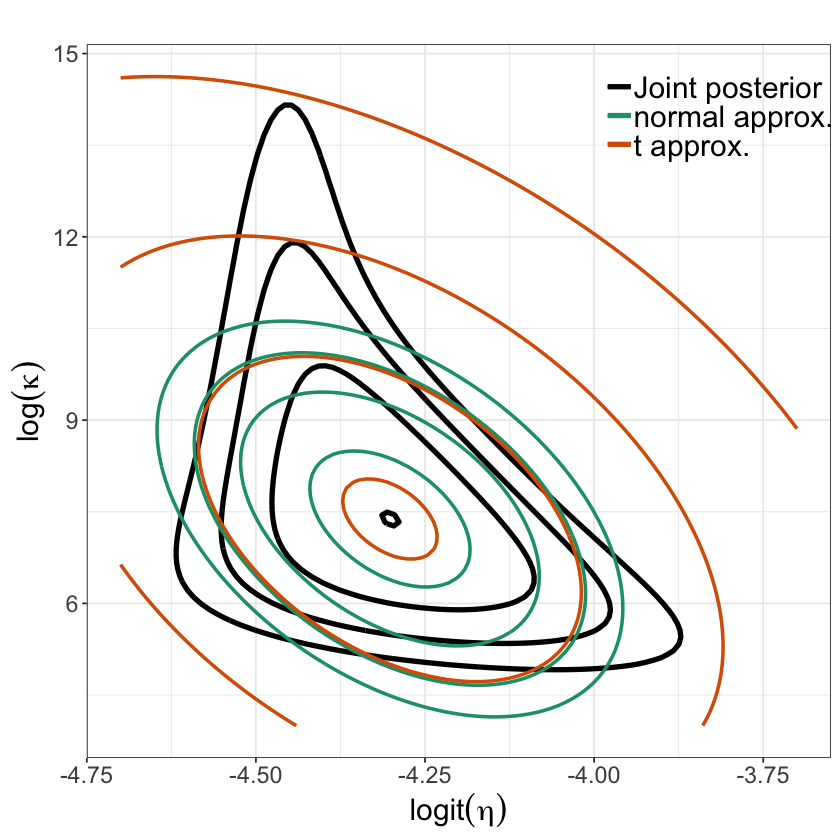

In [33]:
# (1) Proposal density: multivariate t  
# Computes the logarithm of a multivariate t density approximation 
tpar=list(m=fit$mode,var=2*fit$var,df=4)
df2$t.appr <- dmt(as.matrix(df2[,1:2]), 
                  mean=c(tpar$m),S=tpar$var,df=tpar$df,
                  log=TRUE)


p.RSproposal <- ggplot(data=df2) +
  stat_contour(aes(x=ph1,y=ph2,z=post,col='1'),lwd=1.5,
               breaks = log(c(0.001,0.01,0.1,0.99))) +
  stat_contour(aes(x=ph1,y=ph2,z=norm.appr,col='2'),lwd=1,
               breaks = log(c(0.001,0.01,0.1,0.99))) +
  stat_contour(aes(x=ph1,y=ph2,z=t.appr,col='3'),lwd=1,
               breaks = log(c(0.001,0.01,0.1,0.99))) + 
  #coord_cartesian(xlim = limG,ylim = limK) +
  scale_color_manual(values=c('black',col[c(1,3)]), 
                     labels = c("Joint posterior", "normal approx.","t approx.")) +
  labs(title = "", 
       x = expression(logit(eta)), y=expression(log(kappa))) + 
  #guides(fill = FALSE) + 
  theme_bw() +  # Black and white theme
  theme(axis.text=element_text(size=14),
        axis.title.y  = element_text(size=18,angle=90,vjust = 0.5),
        axis.title.x = element_text(size = 18),
        plot.title=element_text(size=18,face="bold"),
        legend.background = element_blank(),
        legend.position = c(0.85, 0.9),
        legend.text= element_text(size = 18),
        legend.title = element_blank())

p.RSproposal

In [34]:
# (2) Computation of the log constant: 
# D=logC (p(theta|x) / p*(theta)  <= C)

# function that computes values of the difference
# between the post. and its proposal d.: log p(theta|x) - log p*(theta) 
RS.logdiff=function(theta,datapar)
{
  # if theta is not a matrix: 
  if(is.list(theta)) theta = data.matrix(theta)
  if(is.vector(theta)) theta = t(matrix(theta))
  
  d = matrix(0,nrow = dim(theta)[1])
  
  data=datapar$data
  tpar=datapar$par
  
  for(i in 1:dim(theta)[1]){
    d[i] = logpost.R(theta[i,],data) - dmt(theta[i,],mean=c(tpar$m),
                                           S=tpar$var,df=tpar$df,log=TRUE)
  }

  return(d)
}

datapar = list(data=data,par=tpar)
start = c(-4.3,7)
cte.fit = laplace(RS.logdiff,start,datapar)
cte.fit$mode

log.cte = as.vector(RS.logdiff(cte.fit$mode,datapar))

paste("log constant:",log.cte)

[1] -4.300028  7.375584

[1] "log constant: -4495.29305551611"

[1] 511   2

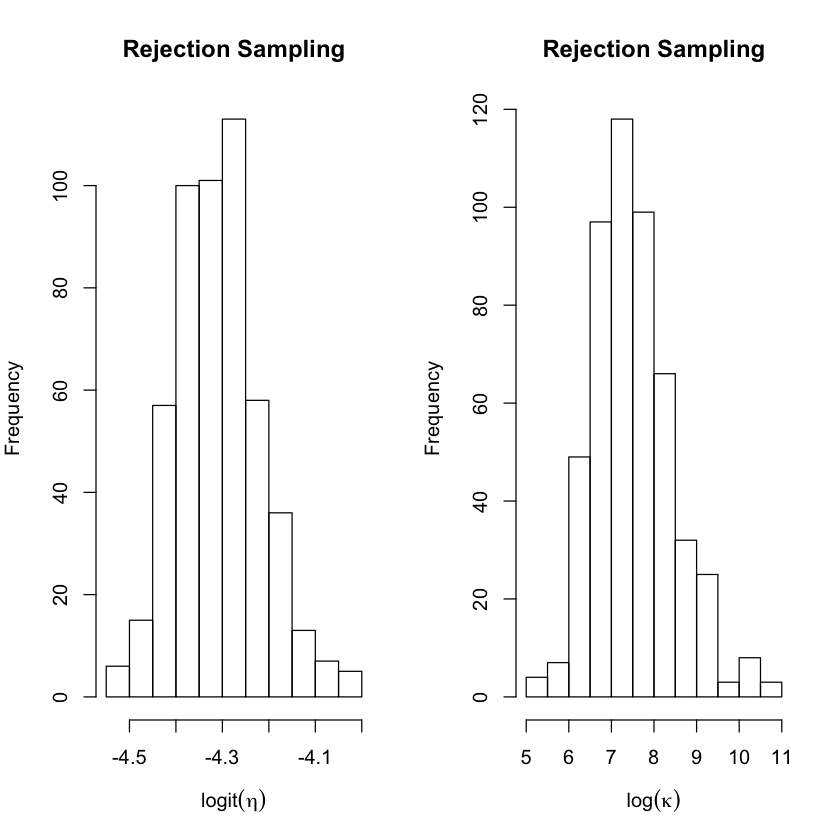

In [36]:
# (3) Obtain draws from the posterior 

# Function to run the Rejection Sampling algorithm 
RS.algo = function (logf, tpar, dmax, n, data) 
{
  # simulate theta from the proposal d.: p*(theta)
  theta = rmt(n, mean = c(tpar$m), S = tpar$var, df = tpar$df)
  # compute the difference: log p(theta|x) - log p*(theta) 
  logd = logf(theta,data) - dmt(theta, mean = c(tpar$m), 
                                        S = tpar$var, df = tpar$df, log = TRUE)
  prob = exp(logd - dmax)
  # from a random sample of an U(0,1), u, accept only if u < prob: 
  return(theta[runif(n) < prob, ])
}



phi.sample = RS.algo(logpost.R,tpar,log.cte,1000,data)
dim(phi.sample)

par(mfrow=c(1,2),mar=c(5, 4, 4, 2), mgp=c(3, 1, 0)) #
hist(phi.sample[,1], xlab = expression(logit(eta)),
     main = "Rejection Sampling")
hist(phi.sample[,2], xlab = expression(log(kappa)),
     main = "Rejection Sampling")


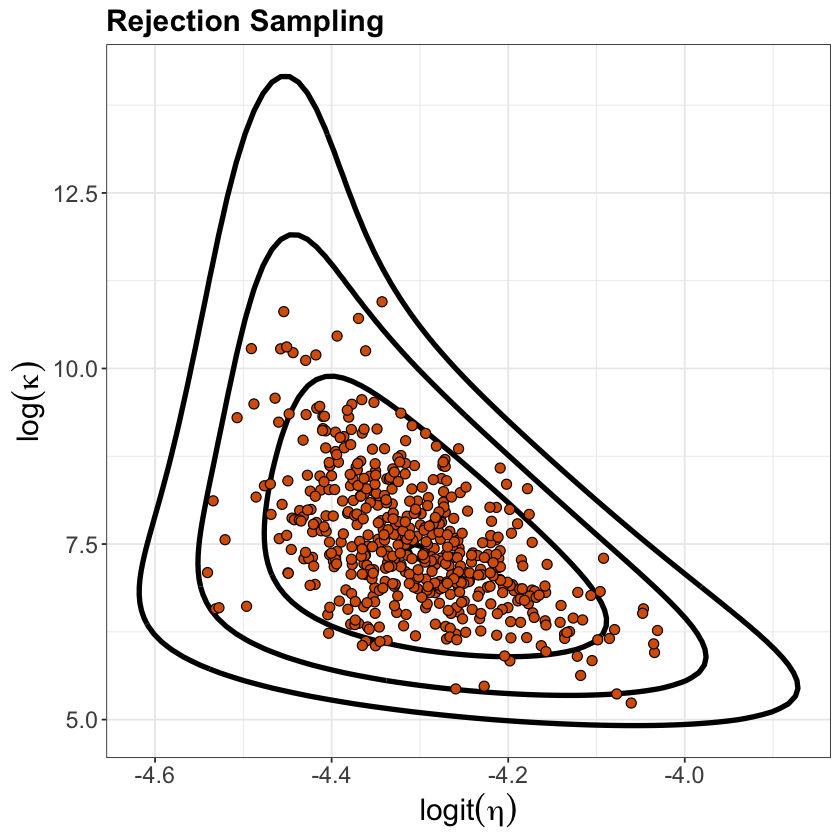

In [39]:
p.RS <- ggplot() +
  stat_contour(data=df2, aes(x=ph1,y=ph2,z=post),col='black',lwd=1.5,
               breaks = log(c(0.001,0.01,0.1,0.99))) +
  geom_point(data=data.frame(ph1=phi.sample[,1],ph2=phi.sample[,2]),
             aes(x=ph1,y=ph2),
             fill = col[3],shape=21,size=2.5) + 
  #coord_cartesian(xlim = limG,ylim = limK) +
  labs(title = "Rejection Sampling", 
       x = expression(logit(eta)), y=expression(log(kappa))) + 
  #guides(fill = FALSE) + 
  theme_bw() +  # Black and white theme
  theme(axis.text=element_text(size=14),
        axis.title.y  = element_text(size=18,angle=90,vjust = 0.5),
        axis.title.x = element_text(size = 18),
        plot.title=element_text(size=18,face="bold"),
        legend.background = element_blank(),
        legend.position = c(0.85, 0.9),
        legend.text= element_text(size = 18),
        legend.title = element_blank())

p.RS

# combine the plots
#grid.arrange(p.RSproposal, p.RS, nrow = 1)

### Approximation of the posterior mean by  Monte Carlo & Rejection Sampling

In [41]:
# approx by sample mean:
po.mean = apply(phi.sample,2,mean) 
# associated simulation std. error = sd/sqrt(m) : 
se = apply(phi.sample,2,sd)/sqrt(dim(phi.sample)[1])

paste("Post mean phi1",round(po.mean[1],4),"+/-",round(se[1],4))
paste("Post mean phi2",round(po.mean[2],4),"+/-",round(se[2],4))


[1] "Post mean phi1 -4.3073 +/- 0.004"

[1] "Post mean phi2 7.5308 +/- 0.0417"

In [42]:
# E(theta)=eta
eta = exp(po.mean[1])/(1+exp(po.mean[1]))
K = exp(po.mean[2])
print(paste("eta=",round(eta,4),"kappa=",round(K,4)))

alfa = eta*K
beta = (1-eta)*K
print(paste("alfa=",round(alfa,4),"beta=",round(beta,4)))

[1] "eta= 0.0133 kappa= 1864.5299"
[1] "alfa= 24.7815 beta= 1839.7483"



# Importance Sampling 


In [43]:
# Function to compute/run the Importance Resampling (Estimate), 
# & Sampling Importance Resampling, 
# for a proposal multivariate t density
IS.SIR = function (h,logf, tpar, n, data) 
{
  # simulate theta from the proposal d.: 
  theta = rmt(n, mean = c(tpar$m), S = tpar$var, df = tpar$df)
  
  # compute the weights on the sample 
  lf = logf(theta,data) # log post
  lp = dmt(theta, mean = c(tpar$m), S = tpar$var, df = tpar$df, 
           log = TRUE)
  # maximum value of the difference of log post - log proposal
  # this value is used in the computation
  # of the weights to prevent possible overflow
  md = max(lf - lp)
  wt = exp(lf - lp - md)
  
  # Evaluate the function of params on the sample
  ht = h(theta)
  
  # Importance Sampling 
  est = matrix(0,nrow = n,ncol = 2)
  for(i in 1:n) est[i,] = wt[i]*ht[i,]
  est = apply(est,2,sum)/sum(wt) # estimate: sample mean
  SEest = c(sqrt(sum((ht[,1]-est[1])^2 * wt^2))/sum(wt),
    sqrt(sum((ht[,2]-est[2])^2 * wt^2))/sum(wt)) # error

  return(list(est = est, se = SEest, theta = theta, wt = wt))
}



# Approximation of the posterior mean from the Importance Sampling Alg.
# h(theta)=theta
h <- function(theta) return(theta)
# E(theta|x)
N=1000
imptsam <- IS.SIR(h,logpost.R,tpar,N,data)

imptsam$est
imptsam$se

[1] -4.308746  7.514459

[1] 0.002824324 0.033246003

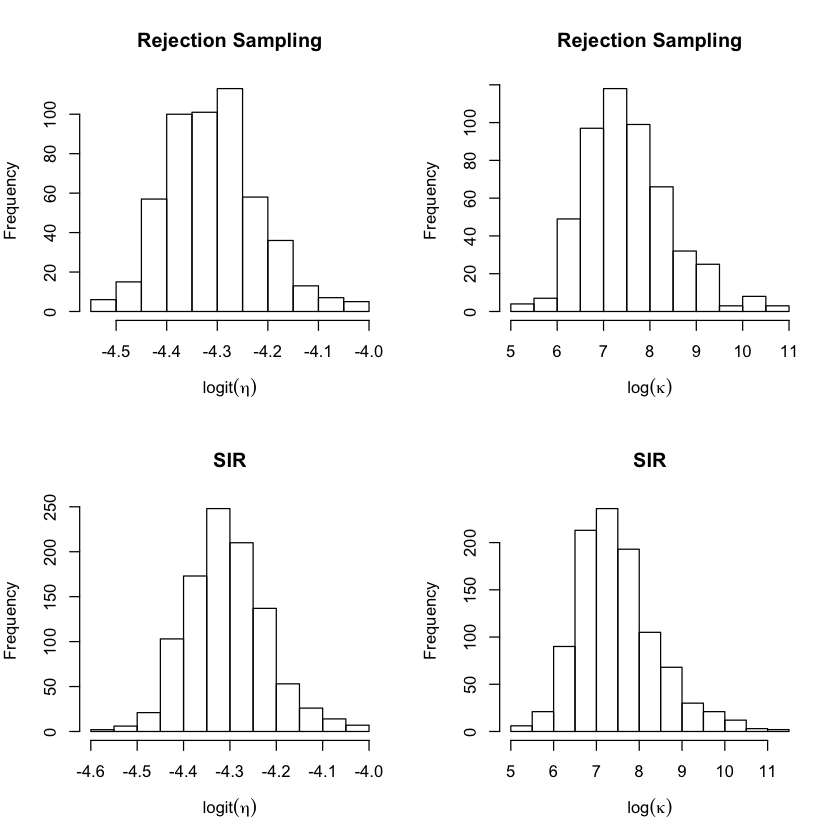

In [44]:
# Sampling Importance Resampling (SIR): 
# Convert the weights to probabilities
probs = imptsam$wt/sum(imptsam$wt)

# New sample, from discrete sample, with replacement, and probs
ind = sample(1:N, size = N, prob = probs, replace = TRUE)
phi.sir = imptsam$theta[ind, ]


# Some plots: RS vs. SIR
par(mfrow=c(2,2),mar=c(5, 4, 4, 2), mgp=c(3, 1, 0)) #
hist(phi.sample[,1], xlab = expression(logit(eta)),
     main = "Rejection Sampling")
hist(phi.sample[,2], xlab = expression(log(kappa)),
     main = "Rejection Sampling")
hist(phi.sir[,1], xlab = expression(logit(eta)),
     main = "SIR")
hist(phi.sir[,2], xlab = expression(log(kappa)),
     main = "SIR")

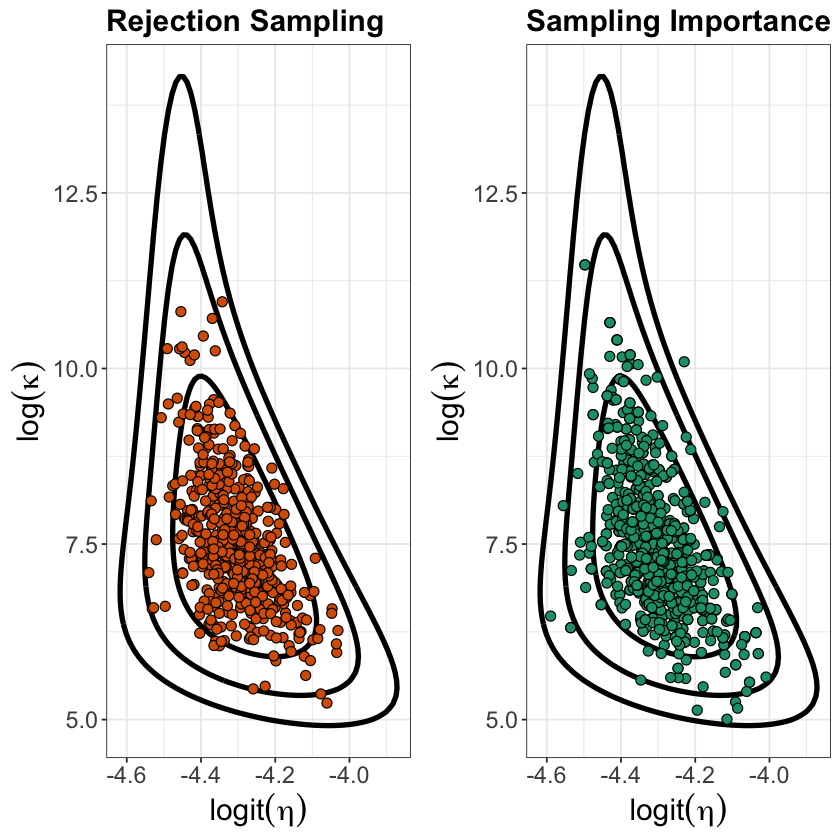

In [46]:
# Plot 
p.IS <- ggplot() +
  stat_contour(data=df2, aes(x=ph1,y=ph2,z=post),col='black',lwd=1.5,
               breaks = log(c(0.001,0.01,0.1,0.99))) +
  geom_point(data=data.frame(ph1=phi.sir[,1],ph2=phi.sir[,2]),
             aes(x=ph1,y=ph2),
             fill = col[1],shape=21,size=2.5) + 
  #coord_cartesian(xlim = limG,ylim = limK) +
  labs(title = "Sampling Importance Resampling", 
       x = expression(logit(eta)), y=expression(log(kappa))) + 
  #guides(fill = FALSE) + 
  theme_bw() +  # Black and white theme
  theme(axis.text=element_text(size=14),
        axis.title.y  = element_text(size=18,angle=90,vjust = 0.5),
        axis.title.x = element_text(size = 18),
        plot.title=element_text(size=18,face="bold"),
        legend.background = element_blank(),
        legend.position = c(0.85, 0.9),
        legend.text= element_text(size = 18),
        legend.title = element_blank())

#p.IS

# combine the plots
grid.arrange(p.RS, p.IS, nrow = 1)

In [47]:
# E(th)=eta
eta = exp(imptsam$est[1])/(1+exp(imptsam$est[1]))
K = exp(imptsam$est[2])
print(paste("eta=",round(eta,4),"kappa=",round(K,4)))

alfa = eta*K
beta = (1-eta)*K
print(paste("alfa=",round(alfa,4),"beta=",round(beta,4)))


[1] "eta= 0.0133 kappa= 1834.3739"
[1] "alfa= 24.3456 beta= 1810.0283"



# Metropolis_Hastings algorithms


[1] 0.4690619

[1] 0.453


Iterations = 1:1001
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1001 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
[1,] -4.308 0.06891 0.002178       0.003358
[2,]  7.470 0.67434 0.021314       0.037640

2. Quantiles for each variable:

       2.5%   25%    50%    75% 97.5%
var1 -4.429 -4.36 -4.301 -4.259 -4.18
var2  6.291  7.00  7.433  7.879  8.98


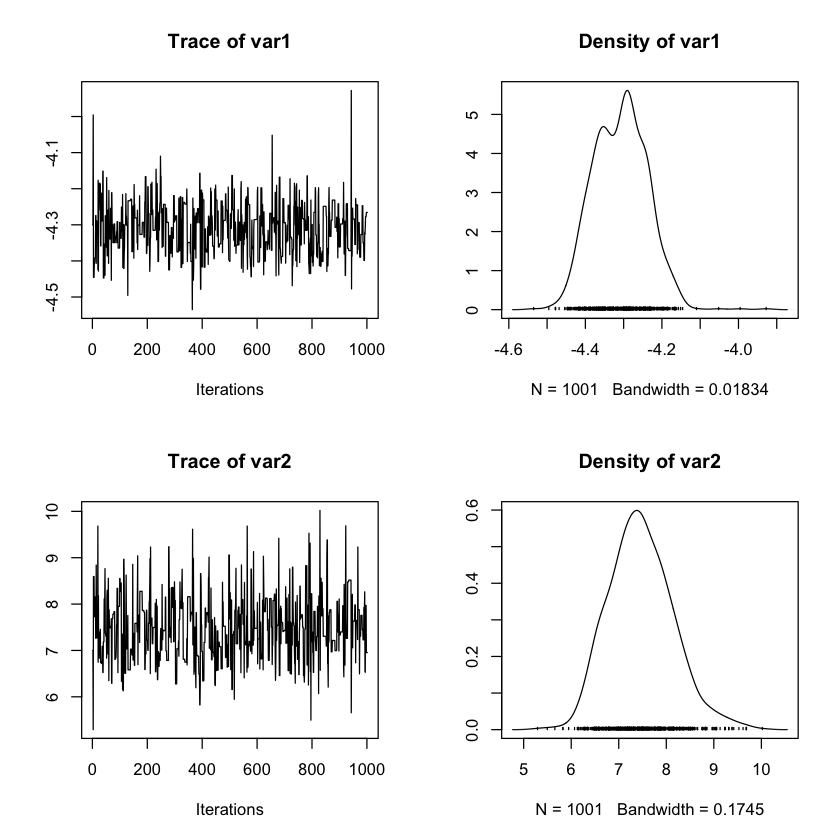

In [51]:
# Load coda library
library(coda)

metropolis <- function(data,startvalue, propar,iterations){
  # Proposal function is a multivariate t, with params given by "propar"
  chain = array(dim = c(iterations+1,2))
  chain[1,] = startvalue
  accept = 0
  for (i in 1:iterations){
    proposal = rmvt(1,sigma = propar$var, delta = propar$m,df = propar$df)
    
    R = exp(logpost.R(proposal,data) - logpost.R(chain[i,],data))
    if (runif(1) < R){
      chain[i+1,] = proposal
      accept = accept + 1
    }else{
      chain[i+1,] = chain[i,]
    }
  }
  #return(chain)
  # The run_metropolis_MCMC() function returns the posterior sample 
  # as a coda object of class “mcmc”
  return(list(par = mcmc(chain),accept.rate=accept/iterations))
}

# So, let’s run the MCMC:
############################
# Starting at a random parameter value
start = c(-4.3,7)
chain.M = metropolis(data,start,tpar,1000)

burnIn = 500
acceptance = 1-mean(duplicated(chain.M$par[-(1:burnIn),]))
acceptance

chain.M$accept.rate

# Run summary and plot results
summary(chain.M$par)
plot(chain.M$par)

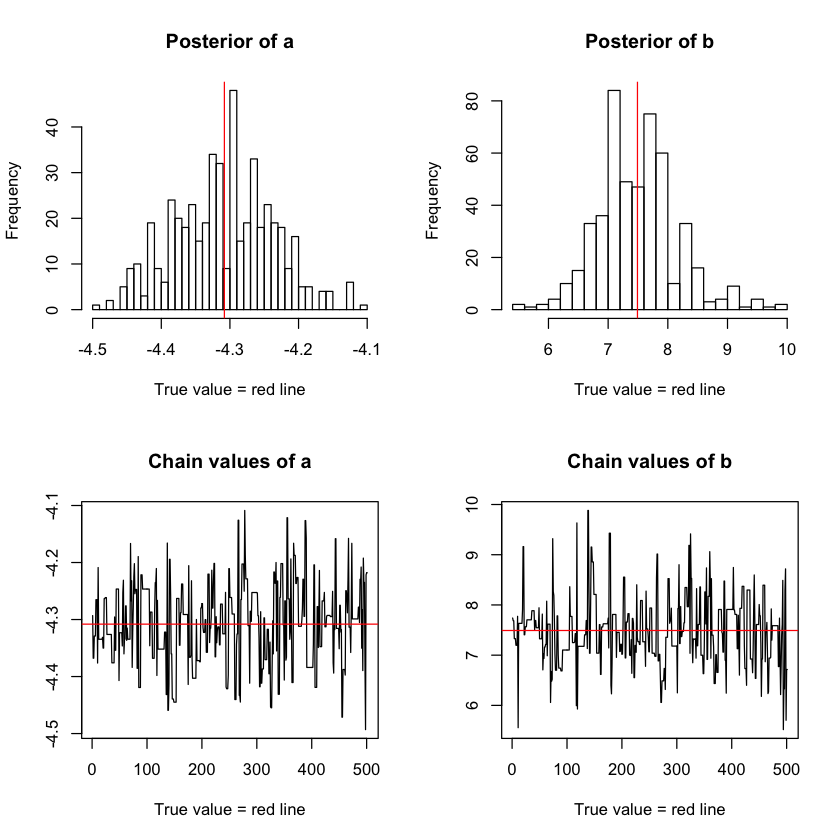

In [58]:
# More plots of the results
par(mfrow = c(2,2))
hist(chain.M$par[-(1:burnIn),1],nclass=30, main="Posterior of a", xlab="True value = red line" )
abline(v = mean(chain.M$par[-(1:burnIn),1]), col="red" )
#abline(v = trueA, col="red" )
hist(chain.M$par[-(1:burnIn),2],nclass=30, main="Posterior of b", xlab="True value = red line")
abline(v = mean(chain.M$par[-(1:burnIn),2]), col="red" )
#abline(v = trueB, col="red" )
plot(chain.M$par[-(1:burnIn),1], type = "l", xlab="True value = red line" , ylab="",main = "Chain values of a" )
abline(h = mean(chain.M$par[-(1:burnIn),1]), col="red" )
plot(chain.M$par[-(1:burnIn),2], type = "l", xlab="True value = red line" , ylab="", main = "Chain values of b" )
abline(h = mean(chain.M$par[-(1:burnIn),2]), col="red" )


### Random Walk Metropolis Algorithm

[1] 0.4451098

[1] 0.533


Iterations = 1:1001
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1001 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
[1,] -4.299 0.07868 0.002487       0.007597
[2,]  7.611 0.82064 0.025938       0.082902

2. Quantiles for each variable:

       2.5%    25%    50%    75%  97.5%
var1 -4.445 -4.351 -4.303 -4.245 -4.139
var2  6.237  7.064  7.485  8.096  9.464


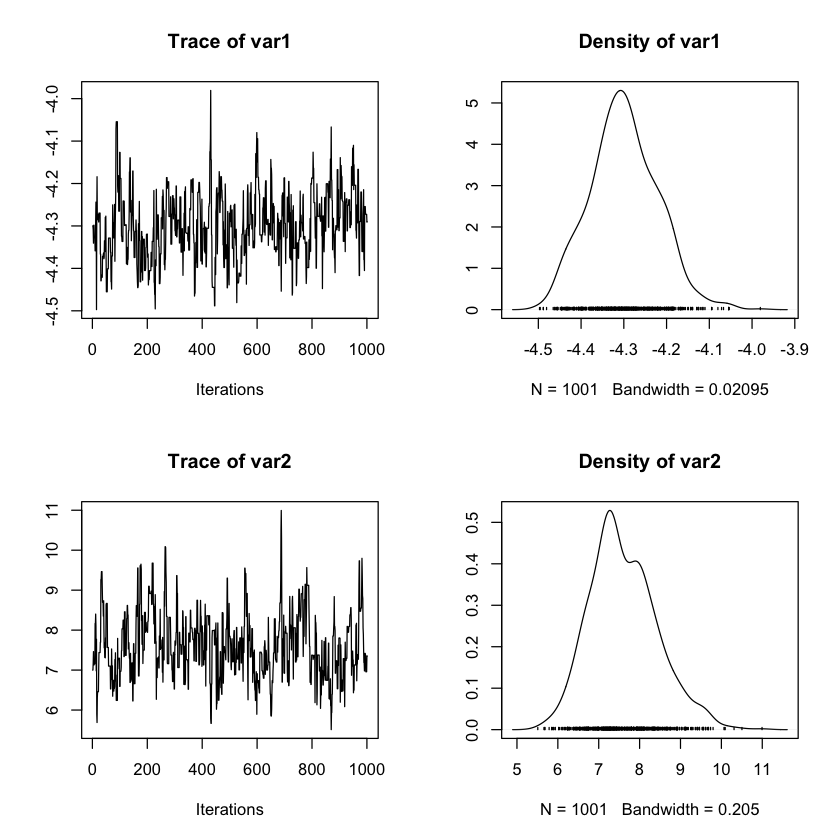

In [52]:
RW_metropolis <- function(data,startvalue, propar,iterations){
  # Proposal function : th.new = th[t-1] + scale*Z, Z~N(0,V)
  chain = array(dim = c(iterations+1,2))
  chain[1,] = startvalue
  accept = 0
  for (i in 1:iterations){
    proposal = chain[i,] + propar$scale*rmvnorm(1, c(0, 0), propar$var)

    R = exp(logpost.R(proposal,data) - logpost.R(chain[i,],data))
    if (runif(1) < R){
      chain[i+1,] = proposal
      accept = accept + 1
    }else{
      chain[i+1,] = chain[i,]
    }
  }
  #return(chain)
  # The run_metropolis_MCMC() function returns the posterior sample 
  # as a coda object of class “mcmc”
  return(list(par = mcmc(chain),accept.rate=accept/iterations))
}

# So, let’s run the MCMC:

start = c(-4.3,7)
chain.M = metropolis(data,start,tpar,1000)

proposal=list(var=fit$var,scale=1)
chain.rwM = RW_metropolis(data,start,proposal,1000)


burnIn = 500
acceptance = 1-mean(duplicated(chain.M$par[-(1:burnIn),]))
acceptance

chain.rwM$accept.rate

# Run summary and plot results
summary(chain.rwM$par)
plot(chain.rwM$par)

### Independent Metropolis Algorithm

[1] 0.4451098

[1] 0.882


Iterations = 1:1001
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1001 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean      SD Naive SE Time-series SE
[1,] -4.306 0.08686 0.002745       0.003521
[2,]  7.462 0.79303 0.025065       0.032115

2. Quantiles for each variable:

       2.5%    25%    50%    75%  97.5%
var1 -4.463 -4.370 -4.310 -4.247 -4.128
var2  6.099  6.904  7.408  7.976  9.131


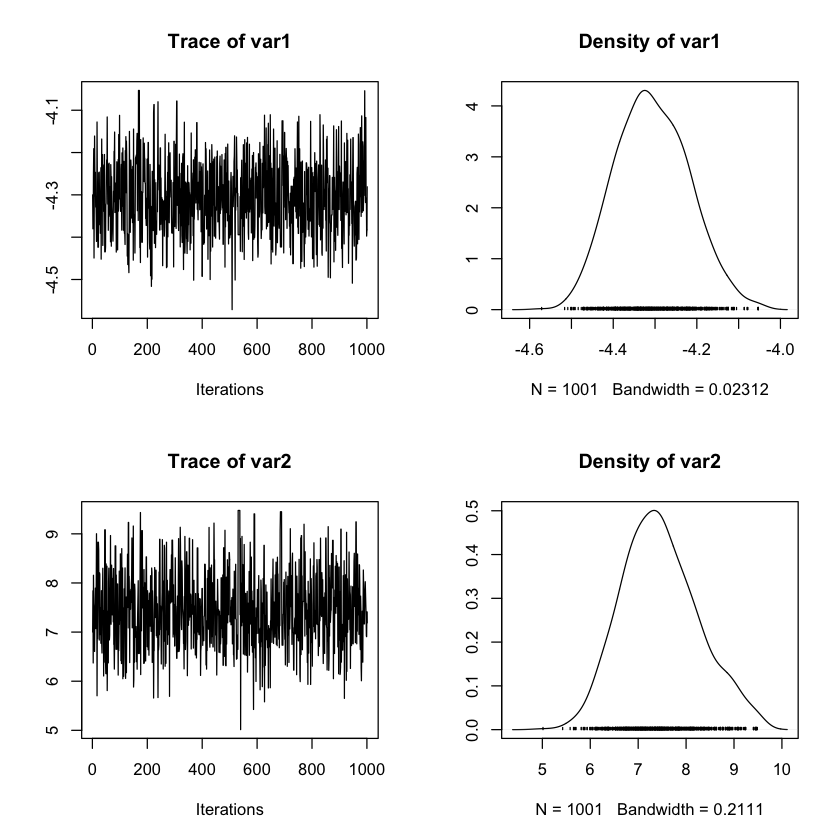

In [53]:
Ind_metropolis <- function(data,startvalue, propar,iterations){
  # Proposal function is a multivariate normal, with params given by "propar"
  chain = array(dim = c(iterations+1,2))
  chain[1,] = startvalue
  accept = 0
  for (i in 1:iterations){
    proposal = rmvnorm(1,propar$m,propar$var)
    
    R = exp(logpost.R(proposal,data) - logpost.R(chain[i,],data) +
                   dmvnorm(chain[i,],propar$m,propar$var,log = T) - 
                   dmvnorm(proposal,propar$m,propar$var,log = T))
    
    if (runif(1) < R){
      chain[i+1,] = proposal
      accept = accept + 1
    }else{
      chain[i+1,] = chain[i,]
    }
  }
  #return(chain)
  # The run_metropolis_MCMC() function returns the posterior sample 
  # as a coda object of class “mcmc”
  return(list(par = mcmc(chain),accept.rate=accept/iterations))
}


# So, let’s run the MCMC:
############################
# Starting at a random parameter value
start = c(-4.3,7)
chain.indM = Ind_metropolis(data,start,npar,1000)


burnIn = 500
acceptance = 1-mean(duplicated(chain.M$par[-(1:burnIn),]))
acceptance

chain.indM$accept.rate


### Summary: #######################

# Run summary and plot results
summary(chain.indM$par)
plot(chain.indM$par)


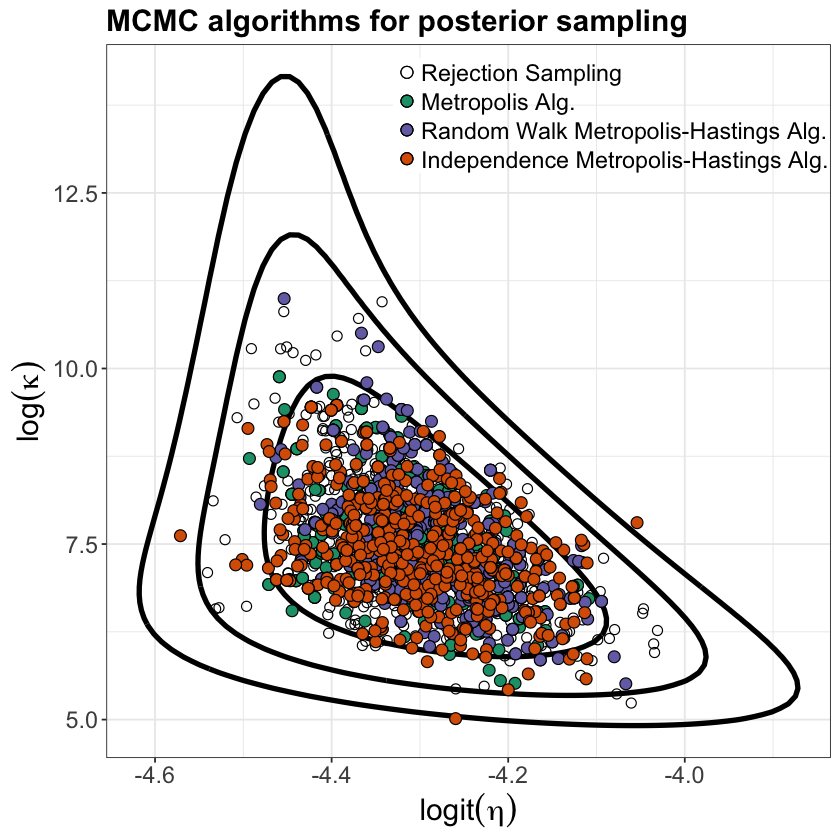

In [57]:
# Compare all the algorithms
p.MH <- ggplot() +
  stat_contour(data=df2, aes(x=ph1,y=ph2,z=post),col='black',lwd=1.5,
               breaks = log(c(0.001,0.01,0.1,0.99))) +
  geom_point(data=data.frame(ph1=phi.sample[,1],ph2=phi.sample[,2]),
             aes(x=ph1,y=ph2,fill = '1'), shape=1,size=2.5) + 
  geom_point(data=data.frame(ph1=chain.M$par[-(1:burnIn),1],ph2=chain.M$par[-(1:burnIn),2]),
             aes(x=ph1,y=ph2,fill = '2'), shape=21,size=3) + 
  geom_point(data=data.frame(ph1=chain.rwM$par[-(1:burnIn),1],ph2=chain.rwM$par[-(1:burnIn),2]),
             aes(x=ph1,y=ph2,fill = '3'), shape=21,size=3) + 
  geom_point(data=data.frame(ph1=chain.indM$par[-(1:burnIn),1],ph2=chain.indM$par[-(1:burnIn),2]),
             aes(x=ph1,y=ph2,fill = '4'), shape=21,size=3) + 
  #coord_cartesian(xlim = limG,ylim = limK) +
  scale_fill_manual(values = c('white',col), labels = c("Rejection Sampling",
                                                        "Metropolis Alg.",
                                                        "Random Walk Metropolis-Hastings Alg.",
                                                        "Independence Metropolis-Hastings Alg.")) +
  labs(title = "MCMC algorithms for posterior sampling", 
       x = expression(logit(eta)), y=expression(log(kappa))) + 
  #guides(fill = FALSE) + 
  theme_bw() +  # Black and white theme
  theme(axis.text=element_text(size=14),
        axis.title.y  = element_text(size=18,angle=90,vjust = 0.5),
        axis.title.x = element_text(size = 18),
        plot.title=element_text(size=18,face="bold"),
        legend.background = element_blank(),
        legend.position = c(0.7, 0.9),
        legend.text= element_text(size = 14),
        legend.title = element_blank())

p.MH
